In [1]:
import os, sys
from IPython.display import Image

## Q1: I love pip 

- Take a piece of python code you wrote (for instance pick one of the exercises you've done for this class). 
- Turn it into a module
- Install it locally
- Deploy on pypi (only using the test-pypi server!)

<div class="alert alert-block alert-warning">
<span class="fa fa-flash"></span> VERY IMPORTANT
    
Both the pypi and test-pypi server are public on the web! Don't compromise your research by putting up something your competitors can use and steal your idea before you've published a paper on it!!! 

</div>


I firstly created a Module named "drawcircles", with the "drawemall.py" .py file containing the function draw_cirlces I am interested in and a "setup.py" file for setup. I installed the module locally using the setup file:

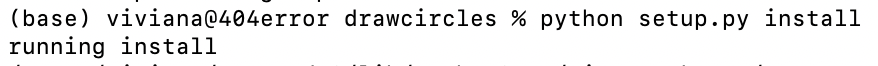

In [2]:
Image(filename='setup.png')


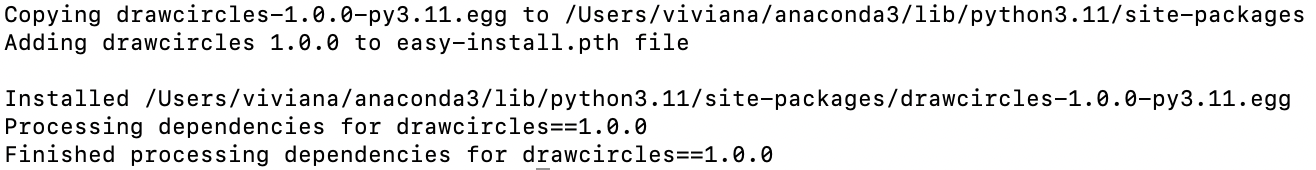

In [3]:
Image(filename='installed.png')

In [4]:
import drawcircles # now it works!

At these point I uploaded my code on PyPI:

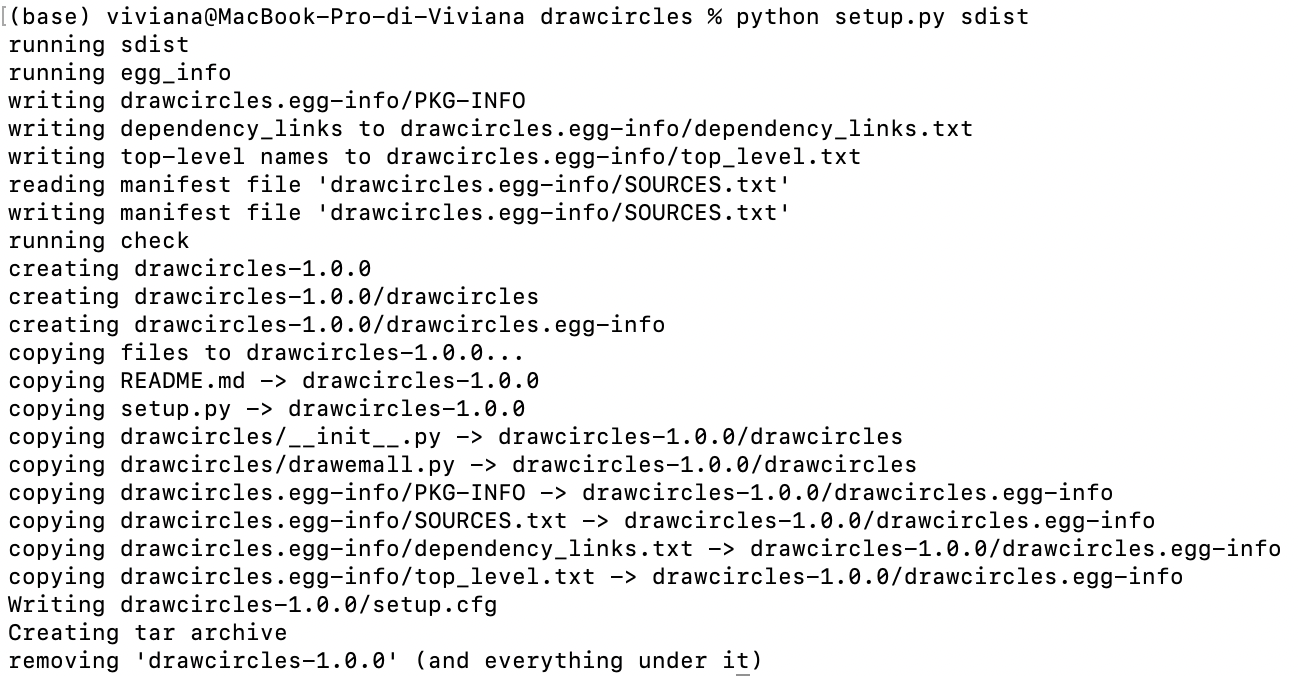

In [5]:
Image(filename='9.png')

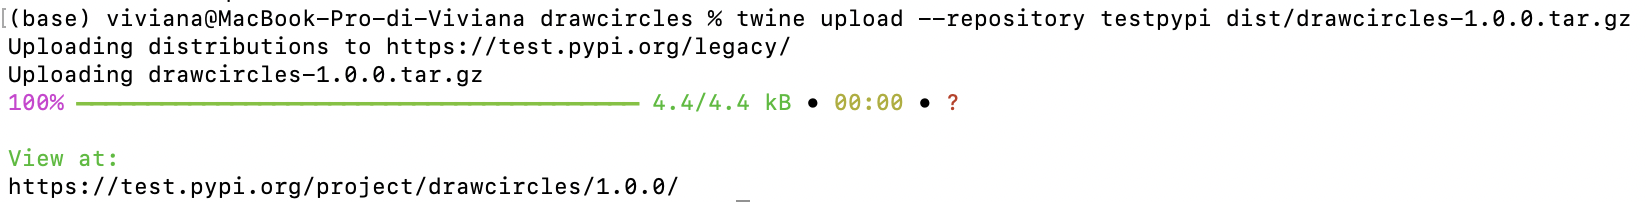

In [6]:
Image(filename='10.png')

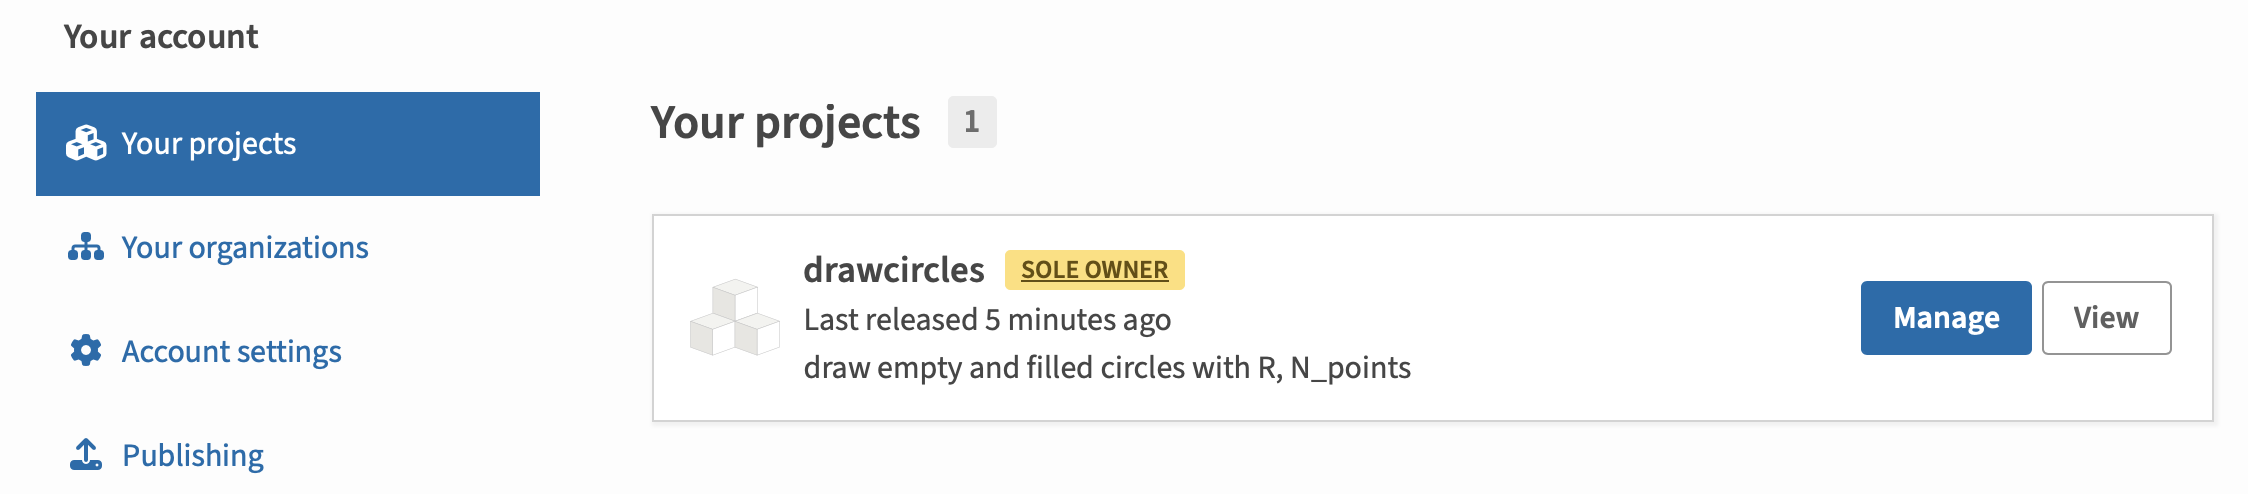

In [7]:
Image(filename='11.png')

## Q4: It's over Anakin, I have the high ground. I hate you! 

Pick a piece of your code that your really hate.  You hate it because it's soooooo slooooow. 
- Profile it.
- Find the culprit
- Rewrite that bottleneck making a better use of numpy arrays, or jitting it with Numba.
- Enjoy your faster code

**You underestimate my power**.

I will show here a piece of code that is terrible (and I knew that) and as close as a basic usage of python as it can be, to fit a spectrum. In my work, at some point I had to deal with hyperfine structured lines (of molecules like C2H), that show two peaks in their spectra instead of just one (as most molecules do). So I had to implement in one of the big codes I was using a method to fit the two-peaked spectra inside the pre-existent routine. This is an old, inefficient version I used as a proxy to have as much control as I could over the procedure and see that it worked, that is very simple and does not use efficient fitting routines: it fits the spectrum with two Gaussians, assumed to have the same width (sigma).

In [38]:
import numpy as np
import time
import matplotlib.pyplot as plt

# import some necessary data: they are a sequence of velocities and an intensity spectrum
velocities = np.load('vel_gau.npy')
spectrum = np.load('spectrum.npy')

In [51]:
# slow double-Gaussian fitting function (with same sigma)
def slow_double_gaussian_fit(velocity, intensity):
    # Double Gaussian function definition
    def double_gaussian(x, amp1, mean1, sigma, amp2, mean2):
        g1 = amp1 * np.exp(-(x - mean1)**2 / (2 * sigma**2))
        g2 = amp2 * np.exp(-(x - mean2)**2 / (2 * sigma**2))
        return g1 + g2

    # Define the search ranges for both Gaussians parameters
    amp_range1 = np.linspace(0.001, 0.1, 30)   # Amplitude 1 range
    mean_range1 = np.linspace(min(velocity), max(velocity), 30)  # Mean 1 range
    sigma_range = np.linspace(10., 5000., 30)  # Shared Sigma range

    amp_range2 = np.linspace(0.001, 0.1, 30)   # Amplitude 2 range
    mean_range2 = np.linspace(min(velocity), max(velocity), 30)  # Mean 2 range

    # Store the best fit parameters and least error
    best_params = None
    least_error = float('inf')

    start_time = time.time()  # Start the timer

    # Brute-force grid search over all parameters for both Gaussians
    for amp1 in amp_range1:
        for mean1 in mean_range1:
            for sigma in sigma_range:
                for amp2 in amp_range2:
                    for mean2 in mean_range2:
                        # Recalculate the double Gaussian for every parameter combination
                        model = double_gaussian(velocity, amp1, mean1, sigma, amp2, mean2)

                        # Compute sum of squared errors
                        error = np.sum((intensity - model)**2)

                        # Check if this is the best fit so far
                        if error < least_error:
                            least_error = error
                            best_params = (amp1, mean1, sigma, amp2, mean2)

    # Print time taken to perform the fitting
    end_time = time.time()
    print(f"Time taken for fitting: {end_time - start_time:.2f} seconds")
    
    # Return the best-fit parameters for both Gaussians
    return best_params



In [52]:
# We run it: it takes < 200 secs:
params = slow_double_gaussian_fit(velocities, spectrum)
print("Fitted parameters (amp1, mean1, sigma, amp2, mean2):", params)


Time taken for fitting: 169.66 seconds
Fitted parameters (amp1, mean1, sigma, amp2, mean2): (0.011241379310344829, -857.2413920163954, 870.3448275862069, 0.011241379310344829, 2618.6206770278186)


In [74]:
# Just to see that it works:
def double_gaussian(x, amp1, mean1, sigma, amp2, mean2):
        g1 = amp1 * np.exp(-(x - mean1)**2 / (2 * sigma**2))
        g2 = amp2 * np.exp(-(x - mean2)**2 / (2 * sigma**2))
        return g1 + g2

# Plot the spectrum and fitted double Gaussian
def plot_spectrum_with_fit(velocity, intensity, fitted_params, model_function):
    amp1, mean1, sigma, amp2, mean2 = fitted_params
    
    # Generate the fitted model curve
    fitted_curve = np.array([model_function(v, amp1, mean1, sigma, amp2, mean2) for v in velocity])
    
    # Plotting 
    plt.figure(figsize=(7, 3))
    plt.plot(velocity, intensity, 'b-', label="Original Spectrum")
    plt.plot(velocity, fitted_curve, 'r--', label="Fitted Double Gaussian", linewidth=2)
    plt.xlabel("Velocity")
    plt.ylabel("Intensity")
    plt.title("Spectrum with Fitted Double Gaussian")
    plt.legend()
    plt.show()

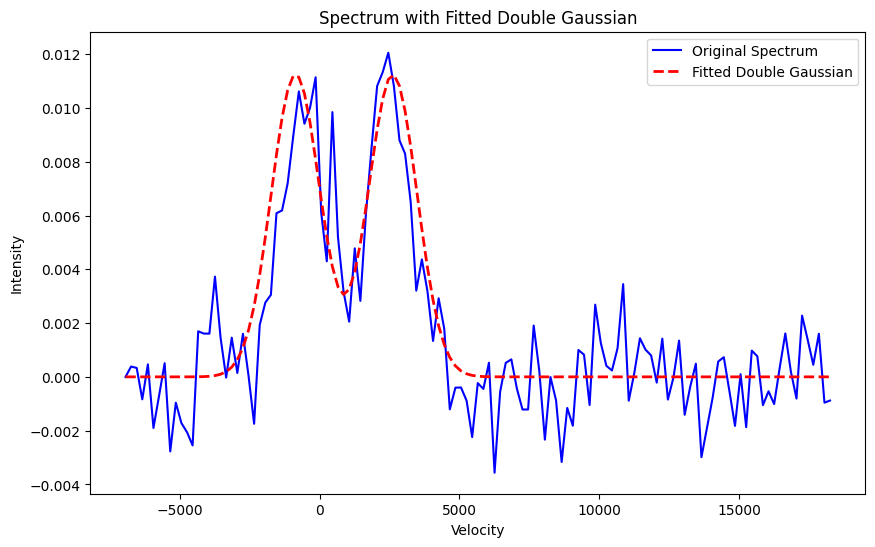

In [55]:
plot_spectrum_with_fit(velocities, spectrum, params, double_gaussian)

At this point we can profile it:

In [57]:
import cProfile 
cProfile.run('slow_double_gaussian_fit(velocities, spectrum)', sort='cumtime')

Time taken for fitting: 191.40 seconds
         194400100 function calls in 191.403 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  191.403  191.403 {built-in method builtins.exec}
        1    0.000    0.000  191.403  191.403 <string>:1(<module>)
        1   27.955   27.955  191.403  191.403 649863542.py:2(slow_double_gaussian_fit)
 24300000  122.648    0.000  122.648    0.000 649863542.py:4(double_gaussian)
 24300000    7.921    0.000   39.728    0.000 fromnumeric.py:2177(sum)
 24300000   10.107    0.000   30.927    0.000 fromnumeric.py:71(_wrapreduction)
 24300000   14.977    0.000   14.977    0.000 {method 'reduce' of 'numpy.ufunc' objects}
 24300000    5.013    0.000    5.013    0.000 fromnumeric.py:72(<dictcomp>)
 24300000    1.071    0.000    1.071    0.000 fromnumeric.py:2172(_sum_dispatcher)
 24300007    0.880    0.000    0.880    0.000 {built-in method builtins.isinstance}
 24300000 

In [59]:
# I also ran it with this option to have a file with the stats in this folder
with cProfile.Profile() as pr:
    slow_double_gaussian_fit(velocities, spectrum)  

pr.dump_stats('my_stats.prof')

Time taken for fitting: 191.53 seconds


It is evident also from the profiling that I am wasting so much time in the (dumb) way of fitting the spectrum, which includes brutal grid search over all parameters for both Gaussians and recalculations of the two functions too many times. So I wrote a more efficient piece of code that does the same but faster, using optimization techniques instead of a brutal grid (so using curve_fit):

In [69]:
from scipy.optimize import curve_fit

# Double Gaussian function definition (external)
def double_gaussian(x, amp1, mean1, sigma, amp2, mean2):
    g1 = amp1 * np.exp(-(x - mean1)**2 / (2 * sigma**2))
    g2 = amp2 * np.exp(-(x - mean2)**2 / (2 * sigma**2))
    return g1 + g2

# Efficient double-Gaussian fitting function (with same sigma)
def fast_double_gaussian_fit(velocity, intensity):
    # Initial guess for parameters
    initial_guess = [0.01, 2500., 1000, 0.01, 500.]
    
    start_time = time.time()  # Start the timer

    # Use curve fit (finally)
    params, covariance = curve_fit(double_gaussian, velocity, intensity, p0=initial_guess)
    
    # Print time taken to perform the fitting
    end_time = time.time()
    print(f"Time taken for fitting: {end_time - start_time:.2f} seconds")
    
    # Return the best-fit parameters for both Gaussians
    return params


In [70]:
params = fast_double_gaussian_fit(velocities, spectrum)
print("Fitted parameters (amp1, mean1, sigma, amp2, mean2):", params)

Time taken for fitting: 0.00 seconds
Fitted parameters (amp1, mean1, sigma, amp2, mean2): [ 1.10572765e-02  2.47907039e+03  7.89010397e+02  1.05044366e-02
 -5.23462414e+02]


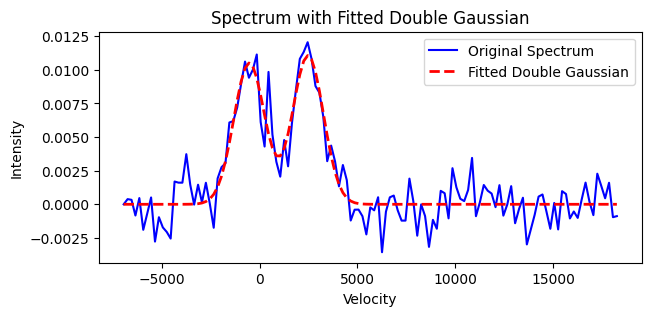

In [75]:
plot_spectrum_with_fit(velocities, spectrum, params, double_gaussian)

In [72]:
import cProfile 
cProfile.run('fast_double_gaussian_fit(velocities, spectrum)', sort='cumtime')

Time taken for fitting: 0.00 seconds
         510 function calls in 0.004 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.004    0.004 {built-in method builtins.exec}
        1    0.000    0.000    0.004    0.004 <string>:1(<module>)
        1    0.000    0.000    0.004    0.004 4170053932.py:10(fast_double_gaussian_fit)
        1    0.000    0.000    0.003    0.003 _minpack_py.py:571(curve_fit)
        1    0.000    0.000    0.003    0.003 _minpack_py.py:281(leastsq)
        1    0.000    0.000    0.002    0.002 {built-in method scipy.optimize._minpack._lmdif}
       40    0.000    0.000    0.002    0.000 _minpack_py.py:503(_memoized_func)
       38    0.000    0.000    0.001    0.000 _minpack_py.py:522(func_wrapped)
       38    0.001    0.000    0.001    0.000 4170053932.py:4(double_gaussian)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.print}
        2    0.0

In [73]:
with cProfile.Profile() as pr:
    fast_double_gaussian_fit(velocities, spectrum)  

pr.dump_stats('my_stats_fast.prof')

Time taken for fitting: 0.00 seconds


We reduced the time A LOT! I hope it didn't hurt too much.